<ipython-input-3-715e3939fe58>:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = combined_df.groupby(['similarity_bin', 'decision', 'Role']).size().unstack(fill_value=0) # Group by the newly created 'similarity_bin' column


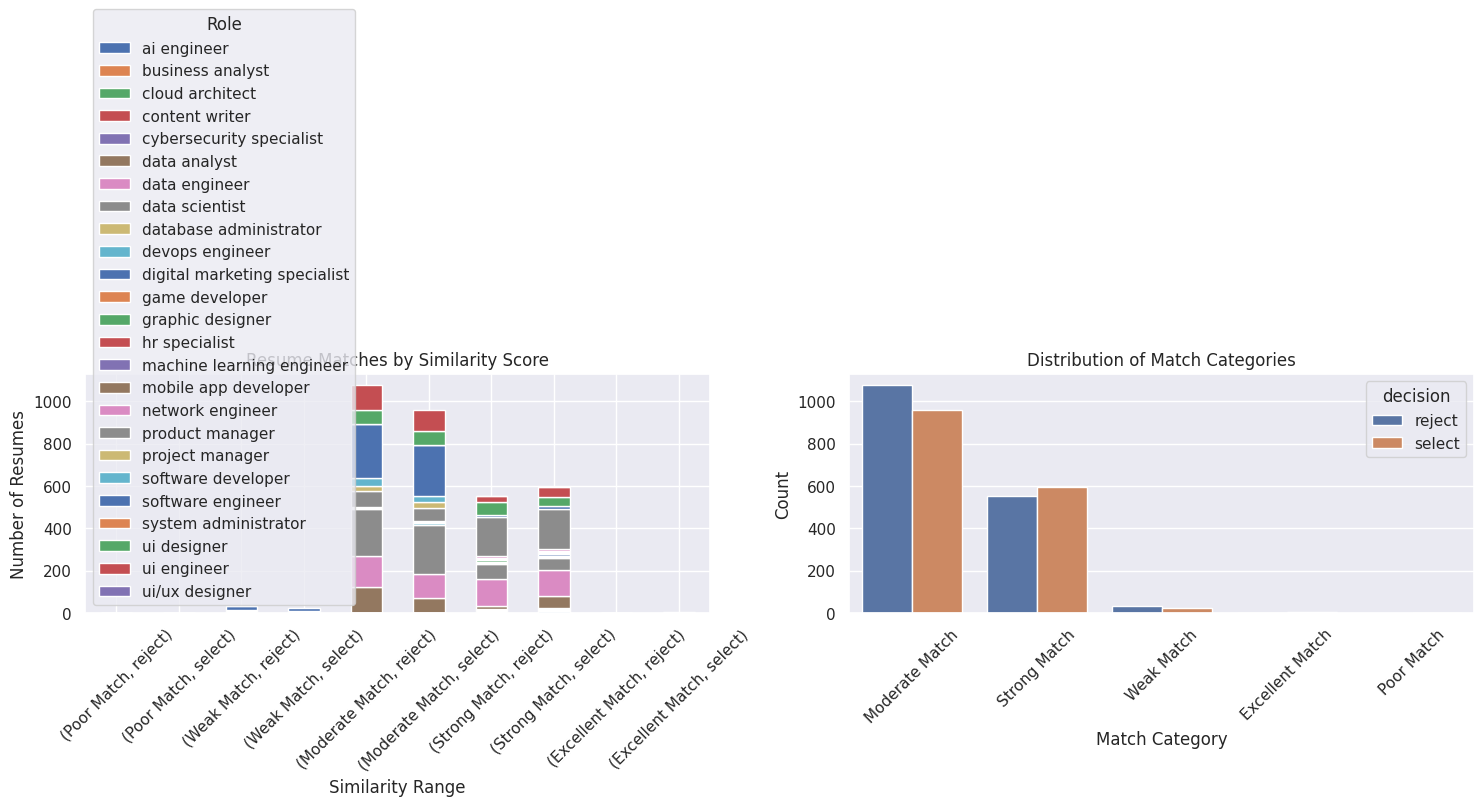

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load data from Excel file
try:
    combined_df = pd.read_excel('cleaned_data.xlsx')
except FileNotFoundError:
    print("Error: The file 'cleaned_data.xlsx' was not found.")
    combined_df = pd.DataFrame()  # Create an empty DataFrame to avoid further errors

# Check if the required columns exist
if 'Job Description' in combined_df.columns and 'Resume' in combined_df.columns:
    # Initialize the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the job descriptions and resumes
    tfidf_job_desc = vectorizer.fit_transform(combined_df['Job Description'])
    tfidf_resumes = vectorizer.transform(combined_df['Resume'])

    # Calculate the cosine similarity between job descriptions and resumes
    combined_df['resume_job_similarity'] = cosine_similarity(tfidf_resumes, tfidf_job_desc).max(axis=1)

    # Add a custom scoring system based on similarity
    def get_match_category(similarity_score):
        if similarity_score >= 0.8: return 'Excellent Match'
        elif similarity_score >= 0.6: return 'Strong Match'
        elif similarity_score >= 0.4: return 'Moderate Match'
        elif similarity_score >= 0.2: return 'Weak Match'
        else: return 'Poor Match'

    combined_df['match_category'] = combined_df['resume_job_similarity'].apply(get_match_category)

    # Add a 'similarity_bin' column based on 'resume_job_similarity'
    combined_df['similarity_bin'] = pd.cut(combined_df['resume_job_similarity'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
                                       labels=['Poor Match', 'Weak Match', 'Moderate Match', 'Strong Match', 'Excellent Match'])

    # Apply the Seaborn style using set_theme()
    sns.set_theme(style="darkgrid")

    # Create subplots for multiple visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # First subplot: Original grouped data
    grouped_data = combined_df.groupby(['similarity_bin', 'decision', 'Role']).size().unstack(fill_value=0) # Group by the newly created 'similarity_bin' column
    grouped_data.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_title('Resume Matches by Similarity Score')
    ax1.set_xlabel('Similarity Range')
    ax1.set_ylabel('Number of Resumes')
    ax1.tick_params(axis='x', rotation=45)

    # Second subplot: Match category distribution
    sns.countplot(data=combined_df, x='match_category', hue='decision', ax=ax2)
    ax2.set_title('Distribution of Match Categories')
    ax2.set_xlabel('Match Category')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

    # Generate summary statistics
    print("\nMatch Category Distribution:")
    print(combined_df['match_category'].value_counts())

    print("\nAverage Similarity Score by Decision:")
    print(combined_df.groupby('decision')['resume_job_similarity'].mean())
else:
    print("Error: Required columns 'job_description' or 'resume' are missing from the DataFrame.")